The hooper 2k method is a correlation developed to estimate the pressure drop a fluid loses given certain pipe fittings

The equation is given in the following equation:

$$K = \frac{K_{1}}{Re} + K_{\infty}(1+\frac{1}{D})$$

Where $K_1$ is the loss factor for the fitting at a reynolds number of 1 and $K_{\infty}$ represents the loss factor at an infinite reynolds number.

In [8]:
#Import necessary libraries

import fluids.fittings as fittings
import fluids
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as ipy
import pandas as pd
import matplotlib.ticker as ticks
from thermo import chemical


#Move Fittings Dictionary into a Pandas Dataframe

HooperCoefficients = pd.DataFrame.from_dict(fittings.Hooper,orient='columns')



The dimensionless variable responsible for characterizing the type of flow is known as the reynolds number. This works by examining the ratio of inertial forces and viscous forces. It can be found below:

$$Re = \frac{D v \rho}{\mu}$$

Where $D$ is the characteristic length, $v$ is the velocity of the flow, $\rho$ is the density of the fluid, and $\mu$ is the viscosity of the fluid.

The function used to calculate this number can be found below:

In [9]:
def calculateReynolds(innerDiam:float,volFlow:float,viscosity:float,density:float)->float:
    '''
    Function takes in pipe inner diameter, fluid velocity, fluid viscosity, and fluid density and returns the reynolds number of the fluid.
    
    Parameters:
        innerDiam (float): inner pipe diameter in inches
        volFlow (float): Volumetric Flowrate in gallons per minute (gpm)
        viscosity (float): dynamic viscosity in centipoise
        density (float): density in pounds per cubic foot
        
    Returns:
        Reynolds Number (float): dimensionless number characterizing fluid flow
    '''
    
    #Converting to SI Units
    innerDiam = innerDiam * 0.0254 #m
    volFlow = volFlow / 15850 #m3/s
    viscosity = viscosity / 1000 #Pa s
    density = density * 16.0185 #kg/m3
    
    #Calculating velocity
    area = np.pi * np.pow(innerDiam,2) / 4 #m2
    velocity = volFlow / area #m/s
    
    #return reynolds number
    return (innerDiam * velocity * density / viscosity)
    

Once the reynolds number is calculated the following function was used to calculate the head loss factor (K)

In [10]:
def hooperHeadLoss(K1:float,Kinf:float,Re:float,D:float)->float:
    '''
    Calculates the head loss factor K given K1, K infinity, the Reynolds number, and the pipe diameter
    
    Parameters:
        K1 (float): Dimensionless constant derived from type of pipe fitting
        Kinf (float): Dimensionless constant derived from type of pipe fitting
        Re (float): Reynolds number Dimensionless constant characterizing flow in pipe
        D (float): pipe diameter (in) which the fluid is flowing in
        
    Return:
        K (float): Dimensionless constant which characterizes the head loss around the bend
        
    '''
    return (K1 / Re) + Kinf*(1+1/D)

The following functions can be evaluated across a large range of reynolds numbers and plotted on a semilog scale to create a figure analagous to fig. 1 in the original Hooper paper

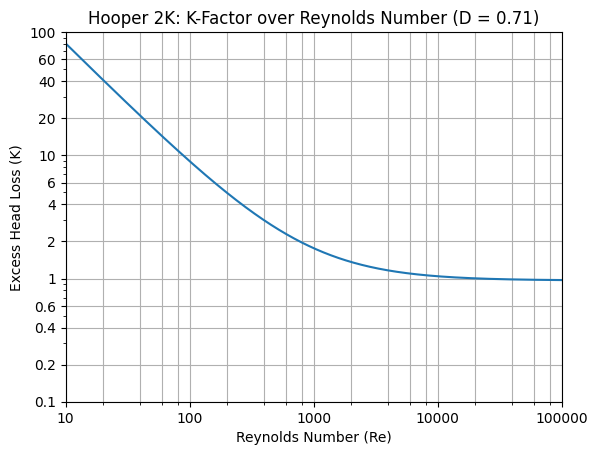

In [11]:
#Create Objects
fig1, ax1 = plt.subplots()

#Create Data
reynoldsRange = np.logspace(1,5,base=10,num=10000)
headLoss = hooperHeadLoss(800,0.40,reynoldsRange,0.71)

#Plot the Data and Adjust Axis Range
plt.loglog(reynoldsRange,headLoss)
ax1.set_ylim([0.1,100])
ax1.set_xlim([10,100000])

#Modify ticks to match paper by Hooper
ax1.set_yticks([0.1, 0.2,0.4,0.6,1,2,4,6,10,20,40,60,100])
ax1.set_yticklabels(['0.1', '0.2','0.4','0.6','1','2','4','6','10','20','40','60','100'])
ax1.xaxis.set_major_formatter(ticks.ScalarFormatter())
ax1.xaxis.set_minor_locator(ticks.LogLocator(base=10.0,subs=[0.2,0.4,0.6,0.8]))

#Add gridlines
ax1.yaxis.grid(which='major')
ax1.xaxis.grid(which='both')

#Format axis labels
ax1.set_xlabel("Reynolds Number (Re)",)
ax1.set_ylabel("Excess Head Loss (K)")
ax1.set_title("Hooper 2K: K-Factor over Reynolds Number (D = 0.71)");

Using the principles outlined above the below interactive allows you to specify material properties and fittings and determine where on the loss curve you lie

In [ ]:
def plotLossCoefficient(fitting:str,massFlow:float,D:str,material:str='water',temperature:float=25,pressure:float=14.7)->int:
    '''
        Given a fitting, a mass flow rate, a diameter, a material, and temperature and pressure of a fluid, the function will return the head loss curve and plot the point on the curve where your specified fluid lies
        
        Parameters:
            fitting (str): Takes in the fitting type as a string and searches the fluids.fittings python library to obtain k1 and Kinf values
            massFlow (float): Takes in a mass flow rate in lb / min
            D (str): Takes in the nominal diameter of a schedule 40 pipe as a string
            material (str): Takes in a fluid which can be found in the thermo.chemical library (Can be a CAS number - defaults to water)
            temperature (float): Takes in a temperature in Celsius (defaults to 25C)
            pressure (float): Takes in a pressure in psi (defaults to 14.7 psi)
        
        Returns:
            exit code:
                1 if ended normally
                0 if ended abnormally
    '''
    
    #Create a pandas dataframe which can store schedule 40 pipe nominal diameters and their corresponding inner diameters
    conversions = {'Nominal': ['1/8','1/4','3/8','1/2','3/4','1','1 1/4','1 1/2','2','2 1/2','3','3 1/2','4','5','6','8','10','12','14','16','18','20','24'],
                'Inner Diameter': [0.27,0.36,0.49,0.62,0.82,1.05,1.38,1.61,2.07,2.47,3.07,3.55,4.03,5.05,6.07,7.98,10.02,11.94,13.13,15.00,16.88,18.81,22.63]}
    df = pd.DataFrame(conversions)
    
    #Find where in the dataframe it finds the nominal diameter input and convert the diameter to the actual inner diameter, then convert to float
    D= df.loc[df['Nominal'] == D, 'Inner Diameter'].values
    D=D[0]
    
    #Search the thermo.chemical library for thermochemical properties of the input material, parameter modifications convert to K and Pa
    chem = chemical.Chemical(material,T=temperature+273.15,P=pressure*6894.76)
    rho = chem.rho
    mu = chem.mu 
    
    #Pull the K1 and K_infinity coefficients from the fluids.fittings library
    K1 = HooperCoefficients[fitting][0]
    Kinf = HooperCoefficients[fitting][1]
    
    #Let the user know if they are working on a liquid
    if chem.phase != 'l':
        print("Not a liquid!")

    #Calculate values for reynolds number
    massFlowReynolds = massFlow * 0.453592 / 60 #Convert from lb/min to kg/sec
    D_reynolds = D * .0254 #Convert from inches to meters

    volFlow = massFlowReynolds / rho #m3/s
    area = np.pi * D_reynolds ** 2 / 4 #m2
    velo = volFlow / area #m/s
    
    #Try and calculate the reynolds number
    try:
        Re = rho * velo * D_reynolds / mu
    except TypeError:
        #IF there is a type error ensure that you are in a valid phase
        print("Please make sure you are in a valid phase!")
    else:
        #If there are no errors continue with the program
        
        print("The Reynolds Number is: " + str(Re))
        
        
        #Create Objects
        fig2, ax2 = plt.subplots()
        
        #Create Data
        reynoldsRange = np.logspace(1,5,base=10,num=10000)
        headLoss = hooperHeadLoss(K1,Kinf,reynoldsRange,D)
        
        #Plot the Data and Adjust Axis Range
        plt.loglog(reynoldsRange,headLoss)
        ax2.set_ylim([0.1,100])
        ax2.set_xlim([10,100000])

        #Modify ticks to match paper by Hooper
        ax2.set_yticks([0.1, 0.2,0.4,0.6,1,2,4,6,10,20,40,60,100])
        ax2.set_yticklabels(['0.1', '0.2','0.4','0.6','1','2','4','6','10','20','40','60','100'])
        ax2.xaxis.set_major_formatter(ticks.ScalarFormatter())
        ax2.xaxis.set_minor_locator(ticks.LogLocator(base=10.0,subs=[0.2,0.4,0.6,0.8]))

        #Add gridlines
        ax2.yaxis.grid(which='major')
        ax2.xaxis.grid(which='both')

        #Format axis labels
        ax2.set_xlabel("Reynolds Number (Re)",)
        ax2.set_ylabel("Excess Head Loss (K)")
        
        #Plot a new red point at the specified fluids properties
        plt.plot(Re,hooperHeadLoss(K1,Kinf,Re,D),'ro')
        
        #return a normal exit code
        return 1
    return 0
        
#Using ipywidgets take in parameters for plotLossCOefficient Function

wideLayout = ipy.Layout(width='525px')

Temp = ipy.FloatText(value=25.,description='Temp (C)',style={'description_width':'180px'},layout=wideLayout)
Pressure = ipy.BoundedFloatText(value=14.7, description='Pressure (psi)',style={'description_width':'180px'},min=.1,max=99999999,layout=wideLayout)
massFlowRate = ipy.BoundedFloatText(value=1,description = 'Mass Flow Rate (lb / min)',style={'description_width':'180px'},min=0.00000001,max=99999999,layout=wideLayout)
dropdownMaterial = ipy.Dropdown(options=['Water','Ethanol','Glycerol','Acetic Acid','Ethylene Glycol','Sulfuric Acid'],value='Water',description='Material',style={'description_width':'180px'},layout=wideLayout)
dropdownPipeDiameters = ipy.Dropdown(options=['1/8','1/4','3/8','1/2','3/4','1','1 1/4','1 1/2','2','2 1/2','3','3 1/2','4','5','6','8','10','12','14','16','18','20','24'],description='S40 Pipe Nominal Diameter',style={'description_width':'180px'},layout=wideLayout)

fittingsList = HooperCoefficients.columns.tolist()
fittingDropdown = ipy.Dropdown(options=fittingsList,description= 'Pipe Fitting',style={'description_width':'180px'},layout=wideLayout)

ipy.interactive(plotLossCoefficient,temperature = Temp,pressure = Pressure,material=dropdownMaterial,D=dropdownPipeDiameters,fitting=fittingDropdown,massFlow=massFlowRate)
    


interactive(children=(Dropdown(description='Pipe Fitting', layout=Layout(width='525px'), options=('Elbow, 90°,…